In [111]:
#lets start with some imports

#Py-ART, simply the best sowftware around.. Give those guys a grant
import pyart

#Boto3 is the AWS SDK
import boto3

#botocore contains core configuration utilities for boto2 and boto3
from botocore.handlers import disable_signing

#Tempory files in Python.. A very useful module
import tempfile

#datetime modules.. very handy!
from datetime import datetime

#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop
import cartopy

from copy import deepcopy

import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import cartopy.io.img_tiles as cimgt

import numpy as np

%matplotlib inline

In [9]:
def open_bucket():
    # So we start with bucket neame
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)

    #So now we connect to the bucket with the radar data
    my_bucket = s3.Bucket(bucket)
    return my_bucket 


def find_my_key(radar_name, desired_datetime):
    """
    Find the key in Amazon s3 corresponding to a particular radar site and 
    datetime
    
    Parameters
    ----------
    radar_name : str
        Four letter radar name
    desired_datetime : datetime
        The date time desired
    Returns
    -------
    my_key : string
        string matching the key for the radar file on AWS s3
    """
    aws_radar = open_bucket()
    bucket = "noaa-nexrad-level2"
    # Create a s3 "client"
    s3 = boto3.resource('s3')
    # Set it to unsigned 
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+radar_name)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix=target_string)]
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix=target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], '%Y%m%d_%H%M%S'))
        except ValueError:
            pass #usually a tar file left in the bucket
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    my_key = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    return my_key, aws_radar


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [91]:
# plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                   fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(cartopy.crs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = cartopy.crs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)


In [29]:
print(find_my_key('KLOT', datetime(2011,1,1,20,10))[0])

2011/01/01/KLOT/KLOT20110101_200901_V03.gz


In [112]:
#Lets look at Hurricane Maria
storm_datetime = datetime(2013,4,8,11,0)

#grab the key for Maria
my_key, my_bucket = find_my_key('KLOT', storm_datetime)
print(my_key)

#create a temporary named file
localfile = tempfile.NamedTemporaryFile()

#fetch the data from AWS S3
my_bucket.download_file(my_key, localfile.name)

#read that file into Py-ART!
radar = pyart.io.read(localfile.name)

2013/04/08/KLOT/KLOT20130408_110040_V06.gz


In [113]:
rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500

israel_radar = deepcopy(radar)

In [114]:
#31.7526° N, 35.2214° E
israel_radar.latitude['data'] = np.array([31.7526])
israel_radar.longitude['data'] = np.array([35.2214])

In [48]:
#Sweep we want to plot
sweep = 0

#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('US/Central')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

Monday April 08 at 06:00 AM CDT


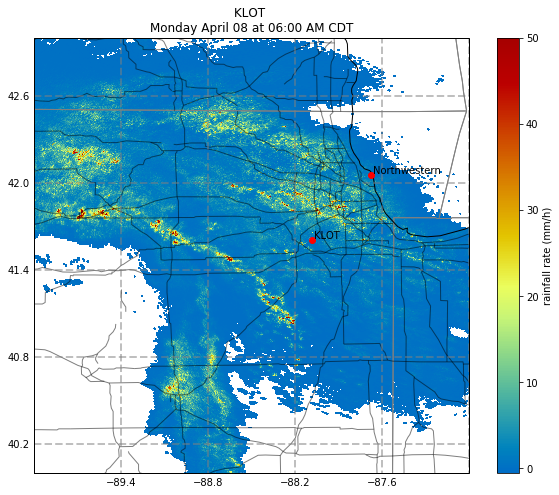

In [101]:
nw_lat = 42.055984
nw_lon = -87.675171

#Set up our figure 41.8781° N, 87.6298° W
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(radar)

#get center of the display for the projection
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
#projection = cartopy.crs.Mercator(
#                central_longitude=lon_0,
#                min_latitude=20, max_latitude=50)

projection = cartopy.crs.PlateCarree()
title = 'KLOT \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_z', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=-90, max_lon=-87, min_lat=40, max_lat=43,
    vmin=-.5, vmax=50, resolution='10m', 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
    lat_lines=[], lon_lines=[])



#def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
#                   fs=None, oset=2000):

scale_bar_left(plt.gca(), linewidth=10, fs=15, col='Black', length=40)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

display.ax.add_feature(states_provinces, edgecolor='gray')
cfeature.LAKES.scale='10m'
display.ax.add_feature(cfeature.LAKES, facecolor='None', edgecolor='black')

display.ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m', facecolor='none',
                                                          edgecolor='black', alpha=0.5))


# Mark the radar
display.plot_point(lon_0, lat_0, label_text='KLOT')

display.plot_point(nw_lon, nw_lat, label_text='Northwestern')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

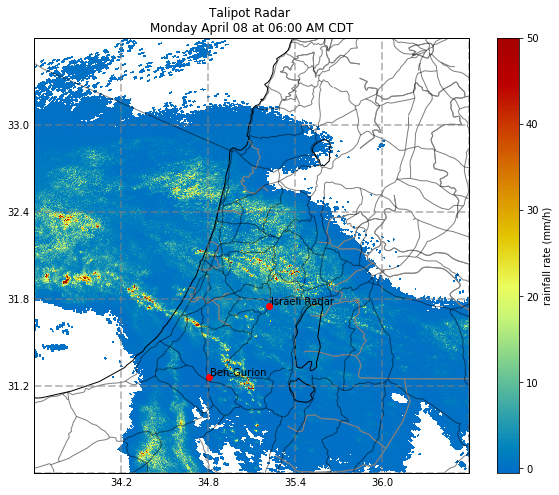

In [117]:
nw_lat = 31.2622
nw_lon = 34.8015

#Set up our figure 41.8781° N, 87.6298° W 31.2622° N, 34.8015° E
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplayCartopy(israel_radar)

#get center of the display for the projection
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
#projection = cartopy.crs.Mercator(
#                central_longitude=lon_0,
#                min_latitude=20, max_latitude=50)

projection = cartopy.crs.PlateCarree()
title = 'Talipot Radar \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'rain_z', sweep, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=33.6, max_lon=36.6, min_lat=30.6, max_lat=33.6,
    vmin=-.5, vmax=50, resolution='10m', 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
    lat_lines=[], lon_lines=[])



#def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
#                   fs=None, oset=2000):

scale_bar_left(plt.gca(), linewidth=10, fs=15, col='Black', length=40)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

display.ax.add_feature(states_provinces, edgecolor='gray')
cfeature.LAKES.scale='10m'
display.ax.add_feature(cfeature.LAKES, facecolor='None', edgecolor='black')

display.ax.add_feature(cartopy.feature.NaturalEarthFeature('cultural', 'roads', '10m', facecolor='none',
                                                          edgecolor='black', alpha=0.5))


# Mark the radar
display.plot_point(lon_0, lat_0, label_text='Israeli Radar')

display.plot_point(nw_lon, nw_lat, label_text='Ben-Gurion')


# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False